<a href="https://colab.research.google.com/github/SmitaPaul7000/All-NLP/blob/master/1.0%20Image%20Captioning/Code/Capstone_proj_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Capstone Project - Image Captioning**





**Image Caption generation** is where for given image, textual description generated automatically.
It requires both methods from computer vision to understand the content of the image and a language model from the field of natural language processing to turn the understanding of the image into words in the right order.

**Note: Flickr8k Dataset link**
http://academictorrents.com/details/9dea07ba660a722ae1008c4c8afdd303b6f6e53b

# Problem with ‘Classic’ Image Captioning Model
The problem with this method is that, when the model is trying to generate the next word of the caption, this word is usually describing only a part of the image. It is unable to capture the essence of the entire input image. Using the whole representation of the image h to condition the generation of each word cannot efficiently produce different words for different parts of the image.This is exactly where an Attention mechanism is helpful.

# Concept of Attention Mechanism:
With an Attention mechanism, the image is first divided into n parts, and we compute with a Convolutional Neural Network (CNN) representations of each part h1,…, hn. When the RNN is generating a new word, the attention mechanism is focusing on the relevant part of the image, so the decoder only uses specific parts of the image.

Image Captioning using Attention Mechanism
We can recognize the figure of the “classic” model for image captioning, but with a new layer of attention model. What is happening when we want to predict the new word of the caption? If we have predicted i words, the hidden state of the LSTM is hi. We select the « relevant » part of the image by using hi as the context. Then, the output of the attention model zi, which is the representation of the image filtered such that only the relevant parts of the image remains, is used as an input for the LSTM. Then, the LSTM predicts a new word and returns a new hidden state hi+1.

# Types of Attention Mechanism :
Attention could be broadly differentiated into 2 types:

Global Attention(Luong’s Attention): Attention is placed on all source positions.
Local Attention(Bahdanau Attention): Attention is placed only on a few source positions.

## Global Attention
Global attention takes into consideration all encoder hidden states to derive the context vector (c(t)). In order to calculate c(t), we compute a(t) which is a variable length alignment vector. The alignment vector is derived by computing a similarity measure between h(t) and h_bar(s) where h(t) is the source hidden state while h_bar(s) is the target hidden state. Similar states in encoder and decoder are actually referring to the same meaning.

##Local Attention
As Global attention focus on all source side words for all target words, it is computationally very expensive and is impractical when translating for long sentences. To overcome this deficiency local attention chooses to focus only on a small subset of the hidden states of the encoder per target word.##

**The entire step-by-step process of applying Attention in Bahdanau’s paper is as follows:**

1. Producing the Encoder Hidden States - Encoder produces hidden states of each element in the input sequence
2. Calculating Alignment Scores between the previous decoder hidden state and each of the encoder’s hidden states are calculated (Note: The last encoder hidden state can be used as the first hidden state in the decoder)
3. Softmaxing the Alignment Scores - the alignment scores for each encoder hidden state are combined and represented in a single vector and subsequently softmaxed
4. Calculating the Context Vector - the encoder hidden states and their respective alignment scores are multiplied to form the context vector
5. Decoding the Output - the context vector is concatenated with the previous decoder output and fed into the Decoder RNN for that time step along with the previous decoder hidden state to produce a new output
6. The process (steps 2-5) repeats itself for each time step of the decoder until an token is produced or output is past the specified maximum length




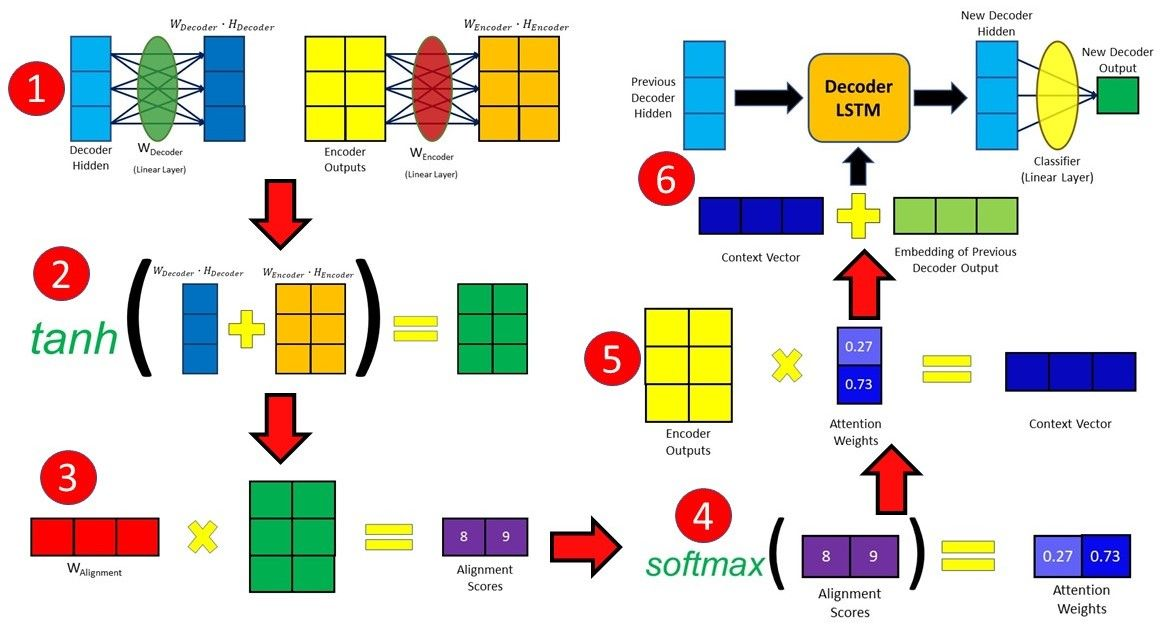

#1.Import

In [0]:
import pandas as pd
import numpy as np
from collections import Counter 
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import pickle
from sklearn.model_selection import train_test_split
import time
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array

Using TensorFlow backend.


#2.Data Sources
Below are Image Data sources :
1. Flickr 8k (containing8k images), 
2. Flickr 30k (containing 30k images), 
3. MS COCO (containing 180k images), 

here using Flickr 8k Dataset

Connect to google drive to fetch data..

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#3.Explore Data

In [0]:
## The location of the Flickr8K_ photos and captions
dir_Flickr_jpg = "/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flicker8k_Dataset"

file_caption = "/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flickr8k_text/Flickr8k.token.txt"


In [0]:
## Read the Flickr caption data
file = open(file_caption,'r')
text = file.read()
file.close()
 

In [0]:
text[1:100]

'000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .'

In [0]:
#split data into dataframe , so to get image name and its description
datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])


In [0]:

data.shape

(40460, 3)

In [0]:
data.head(10)

,filename,index,caption
0,1000268201_693b08cb0e.jpg,0,a child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,1,a girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,2,a little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,3,a little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,4,a little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,0,a black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,1,a black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,2,a black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,3,two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,4,two dogs on pavement moving toward each other .


In [0]:
## Count file name and its description
img_filenames = np.unique(data.filename.values)
print("The number of unique images names : {}".format(len(img_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(data.filename.values).values())

The number of unique images names : 8092
The distribution of the number of captions for each image:


Counter({5: 8092})

Note Total Image are 8092 nd each image has 5 line description.

Remove any other invalid extension of images

In [0]:
#https://www.mkyong.com/regular-expressions/how-to-validate-image-file-extension-with-regular-expression/
import re
for i in data["filename"]:
    x = re.search("([^\s]+(\.(?i)(jpg|png|gif|bmp))$)", i)
    if (x):
        pass
    else:
        print(f"different image extension!: {i}")
        


different image extension!: 2258277193_586949ec62.jpg.1
different image extension!: 2258277193_586949ec62.jpg.1
different image extension!: 2258277193_586949ec62.jpg.1
different image extension!: 2258277193_586949ec62.jpg.1
different image extension!: 2258277193_586949ec62.jpg.1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Flags not at the start of the expression '([^\\s]+(\\.(?i)(jpg|p' (truncated)
  This is separate from the ipykernel package so we can avoid doing imports until


Remove invalid image

In [0]:
data = data[data.filename != '2258277193_586949ec62.jpg.1']

In [0]:
## Count file name and its description
img_filenames = np.unique(data.filename.values)
print("The number of unique images names : {}".format(len(img_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(data.filename.values).values())

The number of unique images names : 8091
The distribution of the number of captions for each image:


Counter({5: 8091})

 # 4. Check images and their respective captions 

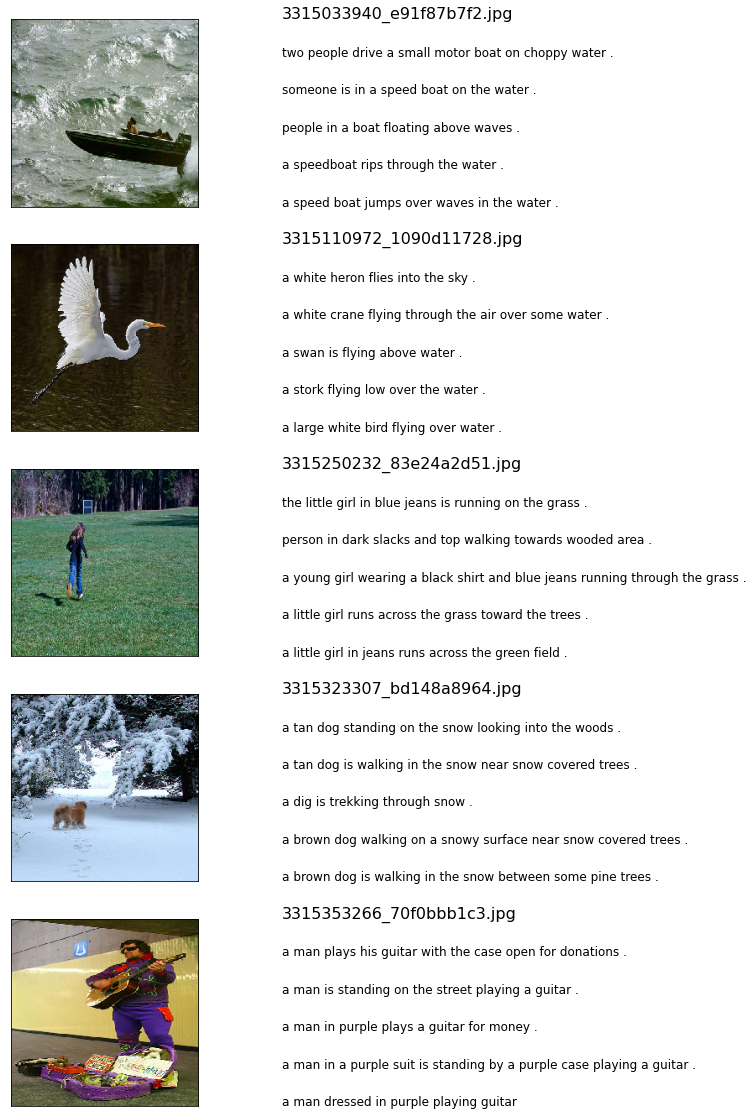

In [0]:


npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))

for imgName in img_filenames[5010:5015]:
    filename = dir_Flickr_jpg + '/' + imgName
    captions = list(data["caption"].loc[data["filename"]==imgName].values)
    
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))

    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=12)
    ax.text(0,i+1,imgName,fontsize= 16)
    count += 1

plt.show()

## Check Size of images


Shape of the image: (334, 500, 3)


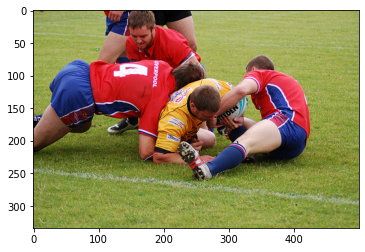

In [0]:
img1= plt.imread(dir_Flickr_jpg + "/" + img_filenames[7000])
plt.imshow(img1)
print(f"Shape of the image: {img1.shape}")

Shape of the image: (375, 500, 3)


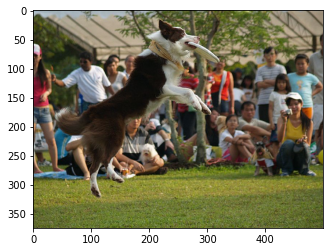

In [0]:
img1= plt.imread(dir_Flickr_jpg + "/" + img_filenames[100])
plt.imshow(img1)
print(f"Shape of the image: {img1.shape}")

All images are in different dimension  (333, 500, 3) or (375, 500, 3)
Need to resize all image in same dimensions

# 5.Put Caption and Image data inplace, so further it can used for modelling

Preprocessing the captions (adding < start > and  < end > tags to every caption), so that out ML model understands the starting and ending of each caption.

In [0]:
# Caption preprocessing, 
# Add start and end sequence tokens
# To Do: concat al description in one, separate it by full stop. and check ,odel performance

all_captions = []

for caption  in data["caption"].astype(str):
    caption = '<start> ' + caption+ ' <end>'
    all_captions.append(caption)
all_captions[:1]

['<start> a child in a pink dress is climbing up a set of stairs in an entry way . <end>']

Prepare whole path for all images

In [0]:
all_img_name_vector = []

for annot in data["filename"]:
    full_image_path = dir_Flickr_jpg + "/" + annot

    all_img_name_vector.append(full_image_path)
all_img_name_vector[:2]

['/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flicker8k_Dataset/1000268201_693b08cb0e.jpg']

In [0]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 40455
len(all_captions) : 40455


In [0]:
# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1010)

In [0]:
# Select the first 40000 captions from the shuffled set
#To Do: remove this code..  not needed

num_examples = 40000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]
print(f"priviously we had {len(all_captions)} captions, and Now we have {len(train_captions)}.")

priviously we had 40455 captions, and Now we have 40000.


In [0]:
len(img_name_vector)

40000

In [0]:
type(train_captions)
#list

len(train_captions)
#40000

train_captions[10:15]

['<start> a brown dog digs in the sand . <end>',
 '<start> a brown and white dog chasing a ball on some grass . <end>',
 '<start> two muzzled greyhound dogs running around a track <end>',
 '<start> two women have their arms around each other and are smiling . <end>',
 '<start> wet dog shaking off water on beach <end>']

# 6.Pickling caption and path for images

In [0]:
dbfile1 = open('/content/drive/My Drive/Colab Notebooks/_ic/results/Inception_attention/train_captions', 'ab')   
dbfile2 = open('/content/drive/My Drive/Colab Notebooks/_ic/results/Inception_attention/img_name_vector', 'ab')    

pickle.dump(train_captions, dbfile1)   
pickle.dump(img_name_vector, dbfile2)                    
dbfile1.close() 
dbfile2.close()

# 7.Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:

Resizing the image to 299px by 299px
Preprocess the images using the preprocess_input method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [0]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (256, 256))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Extract Image Features by InceptionV3
Initialize InceptionV3 and load the pretrained Imagenet weights
Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is 8x8x2048. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
After all the images are passed through the network, you pickle the dictionary and save it to disk.

To Do: Explanation for IncepationV3

In [0]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input

#Removing last layer
hidden_layer = image_model.layers[-1].output

inceptionV3_img_fet_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 2s 0us/step


In [0]:
#inceptionV3_img_fet_model.summary()
img_name_vector[1:5]

['/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flicker8k_Dataset/2304444199_05386d2e9c.jpg',
 '/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flicker8k_Dataset/2245916742_73af13c733.jpg',
 '/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flicker8k_Dataset/549887636_0ea5ae4739.jpg',
 '/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flicker8k_Dataset/3474912569_7165dc1d06.jpg']

Resize Image 256px X  256px 

and create bath of 16 images
To Do: Chnage batch size and check


In [0]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

## resizing the image to 299px by 299px
## create 16 baths
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

print(f"Let's check the BatchDataset shapes--> {image_dataset}")

Let's check the BatchDataset shapes--> <BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.string)>


In [0]:
type(image_dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

#8.Features extraction form InceptionV3 Model

## One Time Run this code

In [0]:
?

In [0]:
%%time
#one time script.. nest time direclty use .npy files(image features)
for img, path in image_dataset:
 

  #path = tf tensor with 16 batch of image files
  #img = tf (16, 299, 299, 3)
  
  batch_features = inceptionV3_img_fet_model(img)
  # batch_features shape=(16, 8, 8, 2048)

  
  batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))  
  #batch_features.shape =(16, 64, 2048)
  
  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")    
    ## Save an array to a binary file in NumPy .npy format, in same location where image present
    np.save(path_of_feature, bf.numpy())
  

OSError: ignored

In [0]:
print(batch_features.numpy().shape)
bf.numpy().shape

NameError: ignored

In [0]:
path_of_feature

'/content/drive/My Drive/Colab Notebooks/dataset/Flickr8k_text/MainFlicker8K/Flicker8k_Dataset/997722733_0cb5439472.jpg'

In [0]:
train_captions[1], img_name_vector[1]

#9.Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown). For words not appearing in the vocabulary we will give it <unk> notation
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to be the same length as the longest one.

In [0]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

In [0]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [0]:
# Create the tokenized vectors
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)


Then we will create vector notations for each word in our vocabulary.
Now that we have got the sequences to the words in our captions, the sequences are of different length. So, we need pad the sequences to the maximum length of the captions.

In [0]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [0]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

# 10.Split the data into training and testing

Splitting the dataset(image and captions) into 80:20 ratio i.e.[train:test]

In [0]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [0]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

# 11.Create a tf.data dataset for training

In [0]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [0]:
# Load the numpy files.. image features
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# 12.Model


In this example, you extract the features from the lower convolutional layer of VGG16 giving us a vector of shape (224, 224, 3).

Then squash that to a shape of (64, 512).

This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).

The RNN (here GRU) attends over the image to predict the next word.


In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [0]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [0]:
embedding_dim

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

#13.Checkpoint 
Saving Checkpoint TensorFlow objects provide an easy automatic mechanism for saving and restoring the values of variables they use. All prefixes are grouped together in a single checkpoint file ('./tf_ckpts/checkpoint') where the CheckpointManager saves its state.

Checkpoints capture the exact value of all parameters (tf.Variable objects) used by a model. Checkpoints do not contain any description of the computation defined by the model and thus are typically only useful when source code that will use the saved parameter values is available.

In [0]:
checkpoint_path_ckpt = "./checkpoint_final/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path_ckpt, max_to_keep=5)

In [0]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

#14.Training 
Now we extract the features stored in the respective .npy files and then pass those features through the encoder. 

The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder. 

The decoder returns the predictions and the decoder hidden state. 
The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss. Use teacher forcing to decide the next input to the decoder. Teacher forcing is a method for quickly and efficiently training recurrent neural network models that use the ground truth from a prior time step as input. Teacher forcing is the technique where the target word is passed as the next input to the decoder.

The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [0]:
loss_plot = []

In [0]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

## Epochs and Training

In [0]:
%%time
EPOCHS = 35
#Wall time: 1h 20min 29s
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [0]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#15.Evaluation

In [0]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot


def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [0]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
print(rid)
image = img_name_val[rid]
print(image)
print(cap_val[rid])
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

#16.Bilingual evaluation understudy (BLEU)

In [0]:
# captions on the validation set


# longer candidate
from nltk.translate.bleu_score import sentence_bleu

rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)


first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

#remove "<unk>" in result
for i in result:
    if i=="<unk>":
        result.remove(i)


#remove <end> from result         
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result_final
score = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
print("--"*10)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

print(f"time took to Predict: {round(time.time()-start)} sec")
# opening the image
Image.open(img_name_val[rid])

#16.1 METEOR Score

In [0]:
# from nltk.translate.meteor_score import meteor_score

# hypothesis1 = 'It is a guide to action which ensures that the military always obeys the commands of the party'
# hypothesis2 = 'It is to insure the troops forever hearing the activity guidebook that party direct'

# reference1 = 'It is a guide to action that ensures that the military will forever heed Party commands'
# reference2 = 'It is the guiding principle which guarantees the military forces always being under the command of the Party'
# reference3 = 'It is the practical guide for the army always to heed the directions of the party'

# round(meteor_score([reference1, reference2, reference3], hypothesis1),4)
# 0.7398

# 17.Caption on unseen image

In [0]:
image_url = 'http://www.bhamgov.org/DPS/Dog_Running.jpg'
image_extension = image_url[-3:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)
print(image_path)
result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [0]:
image_path = '/content/drive/My Drive/Colab Notebooks/dataset/Image Processing with Python course exercise dataset/surfer1.jpg'
result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [0]:
image_path = 'https://commons.wikimedia.org/wiki/Surfing#/media/File:In_the_right_moment_(43728084470).jpg'

image_path = '/content/drive/My Drive/Colab Notebooks/dataset/Image Processing with Python course exercise dataset/her_surfer.jpg'
result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [0]:
image_path = '/content/drive/My Drive/Colab Notebooks/dataset/Image Processing with Python course exercise dataset/chapter 2/dogs_banner.jpg'
result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [0]:
image_path = '/content/drive/My Drive/Colab Notebooks/dataset/Image Processing with Python course exercise dataset/chapter 2/soap_image.jpg'

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [0]:
image_path = '/content/drive/My Drive/Colab Notebooks/dataset/Image Processing with Python course exercise dataset/chapter 1/fruits-2.jpg'

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)